In [1]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics

import pyro.optim as optim
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy
from imblearn.under_sampling import RandomUnderSampler
import pickle
from mpl_toolkits.mplot3d import Axes3D


pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.0')
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
from utils import *
from model import *

/Users/raksh/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Conditional Auto-Regressive Modelling of Crimes in New York City
## Rakshita Raguraman and Shruti Subramaniyam (rr3201, ss5600)

The goal of our project is to model the socio-economic and spatio-temporal crime data of New York in order to predict the potentially high-risk tracts in the city. Our problem is a binary classification problem, (1: high risk and 0: low risk). Spatial auto-correlation is the tendency for adjacent areas to share similar characteristics. Conditional Auto-Regressive (CAR) and Intrinsic Conditional Auto-Regressive (ICAR) models, first introduced by Besag (1974), account for this by pooling information from neighboring regions.

## Data Description

In order to collect the data for our analysis, we decided to use the New York Crime data. Our collection process involved merging 2 publicly available datasets and augmenting those with public buildings like restaurants and bars in the vicinity of the precinct. 

1. Crime data of New York. (add link and add columns)
2. Census data of New York. (add link and add columns)
3. Public spaces. (added using (latitude, longitude) pair of census data and aggregating over all the blocks to get the tract-wise information) 

## Let's have a look at the dataset

## First, let's just start with socio-economic features

In [2]:
data = data_csv('only_space')

<img src="corr.jpeg">

## Based on the above set of correlations, we decided to shorten our list of features to the following: 


In [3]:
features = ['TotalPop','Income','Poverty','Office','Construction','Production','WorkAtHome', 'PrivateWork','SelfEmployed','FamilyWork','restaurants','subway_station']

The above features were collected per census tract of New York. Based on this, we get the number of Felonies, Misdemeanors and Violations for each day. First we set number of crimes as felonies + misdemeanors + violations. Then we aggregated them for each tract by summing over all the days. Then, through empirical means, we determined a reasonable cutoff and offset which will decide whether the area is a high risk or low risk area. 

## Now let's get the dataset

In [4]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload

In [5]:
data, X_nuts_train, y_nuts_train, month_train, X_nuts_test, y_nuts_test, month_test = get_data(data, features, bool_split=BOOL_SPLIT_SPACE, offset=OFFSET_SPACE)

In [6]:
tnse_dict = get_tnse_dict(X_nuts_train, X_nuts_test)

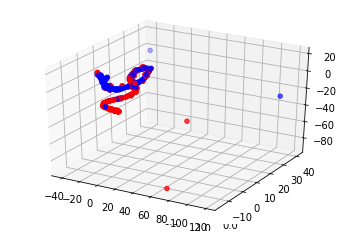

In [7]:
f = low_dim_3d(tnse_dict, y_nuts_test.numpy())

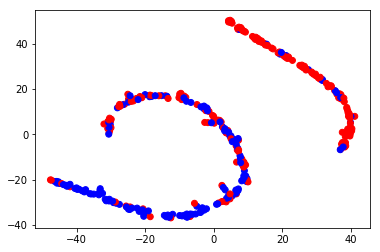

In [8]:
f = low_dim_2d(tnse_dict, y_nuts_test.numpy())

(0, 15000)

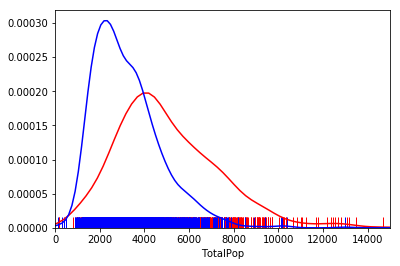

In [9]:
plt.clf()
sns.distplot(data[data['binary_target']==1]['TotalPop'], hist=False, rug=True, color='r');
sns.distplot(data[data['binary_target']==0]['TotalPop'], hist=False, rug=True, color='b');
plt.xlim(0, 15000)

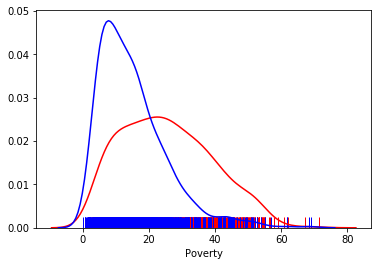

In [10]:
sns.distplot(data[data['binary_target']==1]['Poverty'], hist=False, rug=True, color='r');
sns.distplot(data[data['binary_target']==0]['Poverty'], hist=False, rug=True, color='b');

### We can observe trends in the socio-economic data & crime. Now let us look at spatial data

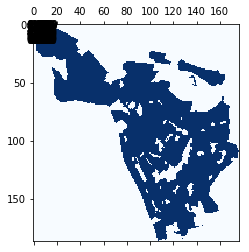

In [11]:
generate_nyc_neighbours()

In [12]:
generate_crime_heatmap()

FileNotFoundError: [Errno 2] File b'raw_data/all_features.csv' does not exist: b'raw_data/all_features.csv'

We can observe that there is a spatial trend as well.

## TODO: Plot binary targets

## Time data Analysis

## Modelling
### Now let us get into the Modelling. First, to begin with, we ran a simple sklearn Logistic Regression model to sort of serve as a baseline. This will also give us an idea of which features have more importance than other. 

In [ ]:
reg = LogisticRegression(C=0.8).fit(X_nuts_train, y_nuts_train)
print('Train Score : ',reg.score(X_nuts_train, y_nuts_train))
print('Test Score :', reg.score(X_nuts_test, y_nuts_test))
print('-'*30)

In [ ]:
f = low_dim_2d(tnse_dict, reg.predict(X_nuts_test))


In [ ]:
f = low_dim_3d(tnse_dict, reg.predict(X_nuts_test))

## Bayesian Baseline Model: 

We now model a bayesian logistic regressor. The features here only depend on the socio-economic patterns, as we are now not considering time or space. 

In [29]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Spatio-temporal using Avg

In [8]:
data = data_csv('time')
features = ['TotalPop','Income','Poverty','Office','Construction','Production','WorkAtHome', 'PrivateWork','SelfEmployed','FamilyWork','restaurants','subway_station']
features.append('monthly_avg')

In [9]:
data, X_nuts_train, y_nuts_train, month_train, X_nuts_test, y_nuts_test, month_test = get_data(data, features, bool_split=BOOL_SPLIT_SPACE, offset=OFFSET_SPACE,has_time_data=True)

In [10]:
node1, node2 = get_nodes(hops=1)

In [ ]:
svi_5_subset, elbo_arr_5_subset = infer(X_nuts_train, y_nuts_train,model_spatio_temporal_linear, guide_spatio_temporal_linear,node1=node1,
                                        node2=node2,month=month_train)

In [ ]:
plt.plot(elbo_arr_5_subset)

In [ ]:
model_preds, y_pred, acc = predict(X_nuts_test, y_nuts_test, model_baseline, guide_baseline,)
result = {'model_preds':model_preds, 'y_pred':y_pred, 'acc':acc, 'elbo_arr':elbo_arr}
import pickle

with open("Results_raksh/model_5_{}_subset".format(int(acc*100)), 'wb') as f:
    pickle.dump(result, f)

# Linear Spatio-temporal model 

In [ ]:
data_yr = pd.read_csv('raw_data/data_year_tract.csv')
data_yr['month'] = data_yr['year']
features = ['TotalPop','Income','Poverty','Office','Construction','Production','WorkAtHome', 'PrivateWork','SelfEmployed','FamilyWork','restaurants','subway_station']

In [ ]:
data_yr, X_nuts_train, y_nuts_train, month_train, X_nuts_test, y_nuts_test, month_test = get_data(data, features, bool_split=BOOL_SPLIT_SPACE, offset=OFFSET_SPACE,
                                                                                               has_time_data=True)


In [ ]:
svi_6_subset, elbo_arr_6_subset = infer(X_nuts_train, y_nuts_train,model_spatio_temporal_linear, guide_spatio_temporal_linear,node1=node1,
                                        node2=node2,month=month_train)

In [ ]:
plt.plot(elbo_arr_6_subset)

In [ ]:
model_preds, y_pred, acc = predict(X_nuts_test, y_nuts_test, model_baseline, guide_baseline,)
result = {'model_preds':model_preds, 'y_pred':y_pred, 'acc':acc, 'elbo_arr':elbo_arr}
import pickle

with open("Results_raksh/model_4_{}_subset".format(int(acc*100)), 'wb') as f:
    pickle.dump(result, f)